In [1]:
import torch
from diffusers import StableDiffusionPipeline, DDIMScheduler
from torch import nn

device = "cuda"

2025-04-17 01:21:15.860572: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744867275.872046   15640 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744867275.875491   15640 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-17 01:21:15.889530: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Could not load bitsandbytes native library: 'NoneType' object has no attribute 'split'
Traceback (most recent call last):
  F

In [2]:
pipe_type = torch.float16 if device == "cuda" else torch.float32
pipe = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", torch_dtype=pipe_type)
pipe = pipe.to(device)
pipe.enable_attention_slicing() 
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
pipe.scheduler.set_timesteps(10)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [3]:
prompt = "a futuristic cityscape"
text_input = pipe.tokenizer(prompt, padding="max_length", max_length=pipe.tokenizer.model_max_length, return_tensors="pt")

In [4]:
text_embeddings = pipe.text_encoder(text_input.input_ids.to(device))[0]

/home/shaunak/.virtualenvs/ML/lib/python3.10/site-packages/torch/nn/modules/linear.py:125: UserWarning: Attempting to use hipBLASLt on an unsupported architecture! Overriding blas backend to hipblas (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:310.)
  return F.linear(input, self.weight, self.bias)


In [5]:
with torch.no_grad():
    latents = torch.randn((1, pipe.unet.in_channels, 64, 64), device=device)  # typical latent size
    latents = latents.to(pipe_type) * pipe.scheduler.init_noise_sigma  # match scheduler expectations

/tmp/ipykernel_15640/754967804.py:2: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((1, pipe.unet.in_channels, 64, 64), device=device)  # typical latent size


In [6]:
text_embeddings.requires_grad_(True)

tensor([[[-0.3884,  0.0229, -0.0523,  ..., -0.4902, -0.3066,  0.0674],
         [ 0.0293, -1.3262,  0.3076,  ..., -0.5259,  0.9746,  0.6660],
         [ 0.1624,  0.0393,  0.7476,  ..., -1.2061, -0.5537,  0.5513],
         ...,
         [ 1.0137,  1.4824, -0.6606,  ...,  1.0176, -0.8145, -0.3308],
         [ 1.0166,  1.4727, -0.6494,  ...,  1.0117, -0.8096, -0.3430],
         [ 1.0342,  1.4346, -0.6187,  ...,  0.9312, -0.7266, -0.3477]]],
       device='cuda:0', dtype=torch.float16, grad_fn=<NativeLayerNormBackward0>)

In [7]:
text_embeddings.requires_grad

True

In [8]:
x = latents

In [9]:
import torch.utils.checkpoint as cp
x_t_list = [x]
for i, t in enumerate(pipe.scheduler.timesteps):
    model_input = pipe.scheduler.scale_model_input(x_t_list[-1], t)
    print(model_input.requires_grad)

    def unet_forward(dummy_input, text_embeds):
    # dummy_input is just there to satisfy checkpoint() — it's ignored
        return pipe.unet(model_input, t, encoder_hidden_states=text_embeds).sample
    
    dummy = torch.tensor(0.0, requires_grad=True, device=model_input.device)
    # Apply checkpointing
    noise_pred = cp.checkpoint(unet_forward, dummy, text_embeddings)

    scheduler_output = pipe.scheduler.step(noise_pred, t, x)
    x_t_list.append(scheduler_output.prev_sample)

False
True


/home/shaunak/.virtualenvs/ML/lib/python3.10/site-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


True
True
True
True
True
True
True
True


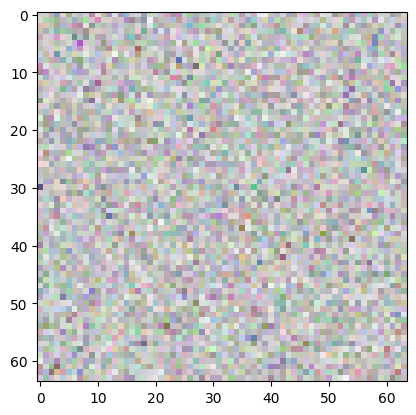

In [10]:
import numpy as np
image = scheduler_output.pred_original_sample
img_np = image.detach().cpu().squeeze().permute(1, 2, 0).numpy().astype(np.float32) # Squeeze if you want to remove the channel dimension
img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())
import matplotlib.pyplot as plt
# Plot using matplotlib
plt.imshow(img_np, cmap='gray')
plt.show()

In [12]:
image_mean = image.mean()
image_mean.backward()

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.